# Imports

In [102]:
import pickle
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
import re
import nltk
import contractions
import spacy
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joaocosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/joaocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [103]:
# Reading the file and converting it to a DataFrame
def read_file_to_dataframe(filename):
    data = []
    
    with open("./data/" + filename, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()  # Remove leading/trailing spaces and newlines
            filme = linha.split('\t')  # Split by tab
            data.append(filme)  # Append the row to the data list
    
    # Convert the list of rows to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df


# Variaveis onde está os ficheiros de treino e o modelo

In [104]:
#file onde já está o modelo treinado"
model=None
newPKL = "joao3"


#limpesa de ficheiro de treino
data="train"
#ficheiro onde vai ser feita ao autoavaliacao
avaliation = "test_no_labels"

In [105]:
print("\033[34mData to DataFrame\n\033[0m")
# Example usage
df = read_file_to_dataframe(data+".txt")
print(df)

Data to DataFrame

                              0          1        2                        3  \
0                  Ela Cheppanu     Telugu  romance                   Ramana   
1     A Nightmare on Elm Street   American   horror             Samuel Bayer   
2               American Gothic   American   horror               John Hough   
3                          Gang  Bollywood    crime              Mazhar Khan   
4            Intimate Relations    British    drama            Charles Frank   
...                         ...        ...      ...                      ...   
8036              Sa 'Yo Lamang   Filipino    drama          Laurice Guillen   
8037          The Lemon Sisters   American    drama             Joyce Chopra   
8038      Dil Ne Phir Yaad Kiya  Bollywood  romance                  Unknown   
8039  Rehnaa Hai Terre Dil Mein  Bollywood  romance            Gautham Menon   
8040             Things to Come    British   sci-fi  William Cameron Menzies   

                    

8041
Average word count: 370.33


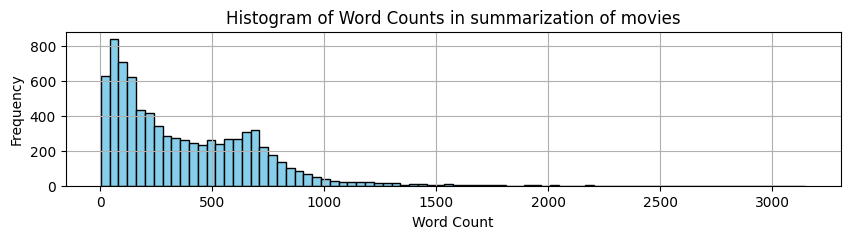

In [106]:
# histogram of word count
print(len(df))

df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


the: 161014
to: 111607
and: 106034
a: 80092
of: 53504
is: 49072
his: 43843
in: 43811
he: 30869
that: 30744


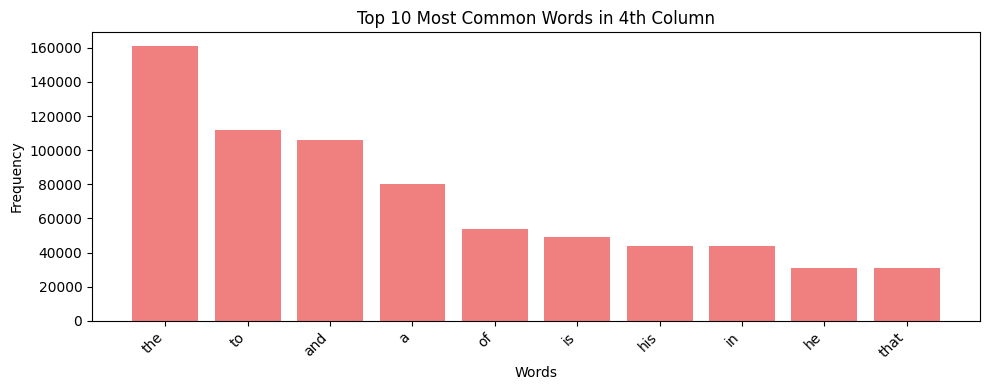

In [107]:
# Flatten all words from the 4th column into a single list
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

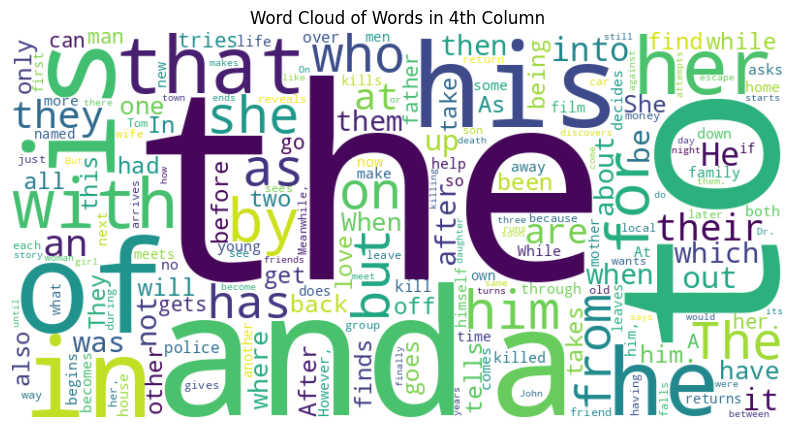

In [108]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

In [109]:
# Check for typos using the pyspellchecker
spell = SpellChecker()
misspelled_words = spell.unknown(all_words)  # Identify misspelled words

# Display the number of potential typos
print(f"Number of potential typos: {len(misspelled_words)}")

# Optionally, print the misspelled words
print("\nPotential typos detected:")
for word in misspelled_words:
    print(word)

Number of potential typos: 110045

Potential typos detected:
tooey's
occultist,
(otto
mccadden
woller),
£200,
cheerily,
he?.
dhruv.
harmail
convy),
lea.
pagek
commissioner.
(samuthirakani)
regas.
swados
wolfgang,
sly,
now-giant
beezel.
(ranjitha)
gautham,
rinaldo.
shocking,
simulcast,
(bloom).
gentleman-scholar
occultistic
murdered,
dyachenko)
harding.
directly.
mind:
skinner,
rangbaaz
pm
(vera
ibarra.
paintings;
actresses.
shirts,
mathis
quincannon
shinji.
amun,
sought-after
babadook.
kakumanu)
prisons.
marguerite,
glazer)
castillos
mcfly,
40th-anniversary
gogol
magnet,
product-placement
neuters,
charlie:
socializing.
pierson
syndicate,
bathgate,
gulzar
callan)
fattema's
celebratory,
húli)
pickings,
(elderly
worship.
benefits,
scores.
colorado's
jessup.
osceola,
cubs,
mera,
mojo's
doolin
(weapons
crichton.
winninger),
vampirism.
succumbs),
raghuvir
calhoun's
violence.
desert.
boldness.
mirrors.
cannons.
millican)
practice,
(harper).
encom,
earth.”
filkins'
brisby
mouse-size
baretti's


## Pre Processamento

In [110]:
# Function to standardize dates
def standardize_dates(text):
    def _month_to_number(month_name):
        try:
            return datetime.strptime(month_name, "%b").month  # Abbreviated month names (e.g., "Feb")
        except ValueError:
            try:
                return datetime.strptime(month_name, "%B").month  # Full month names (e.g., "February")
            except ValueError:
                return None  # Return None for invalid month names

    def _handle_two_digit_year(year):
        if not year:  # If year is None or empty
            return ""
        year = int(year)
        return year + 2000 if year < 100 else year

    # Date normalization using regex
    text = re.sub(
        r'(\b[A-Za-z]+) (\d{1,2})(?:st|nd|rd|th)?(?:,)? (\d{4})?',
        lambda match: (
            f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}/{match.group(3)}"
            if _month_to_number(match.group(1)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}"
            if _month_to_number(match.group(1)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    # Handle formats like "8-Feb-2013"
    text = re.sub(
        r'(\d{1,2})(?:st|nd|rd|th)?[-/.](\b[A-Za-z]+)\b[-/.]?(\d{2,4})?',
        lambda match: (
            f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}/{_handle_two_digit_year(match.group(3))}"
            if _month_to_number(match.group(2)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}"
            if _month_to_number(match.group(2)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    return text

In [111]:
# lowercasing
def lowercase_text(text):
    return text.lower()

In [112]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract and return lemmatized words
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

In [113]:
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words=stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower()]
    return " ".join(filtered_words)

In [114]:
#contractions
def expand_contractions(text):
    if not isinstance(text, str) or not text:
        # Return an empty string or the original text if it's not a valid string
        return text

    try:
        # Use contractions.fix to expand contractions in the text
        return contractions.fix(text)
    except IndexError as e:
        print(f"IndexError encountered: {e}")
        # Optionally return the original text if there's an error
        return text


In [115]:
# Remove punctuation except for specific cases like "Dr." or "Mr."
def remove_punctuation(text):
    # Replace specific abbreviations with placeholders
    text = re.sub(r'\b(Dr|Mr|Ms|Mrs)\.', r'\1_PLACEHOLDER_', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Restore the abbreviations
    text = text.replace('_PLACEHOLDER_', '.')
    
    return text

In [116]:
print("\033[34mPre Processing the data\n\033[0m")

def preprocess_text(text):
    text = expand_contractions(text)       # Step 1: Expand contractions
    text = standardize_dates(text)         # Step 2: Normalize dates
    text = lowercase_text(text)            # Step 3: Convert to lowercase
    text = remove_punctuation(text)        # Step 4: Remove punctuation but keep specific cases
    text = remove_stopwords(text)          # Step 5: Remove stopwords
    # text = lemmatize_text(text)            # Step 6: Lemmatize the text
    return text

# Example usage

Pre Processing the data



In [117]:
df.iloc[:, 4] = df.iloc[:, 4].apply(preprocess_text)

print("\033[32mPre Processing Completed!\n\033[0m")

IndexError encountered: string index out of range
IndexError encountered: string index out of range
Pre Processing Completed!



Average word count: 204.93


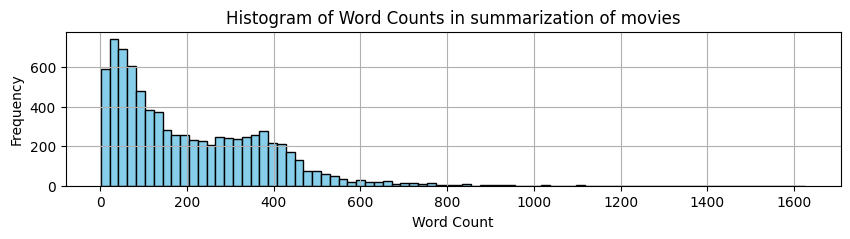

In [118]:
# histogram of word count after pre-processing
df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

one: 6584
back: 5620
tells: 4560
two: 4494
father: 4379
house: 4260
later: 4019
love: 3934
man: 3863
home: 3855


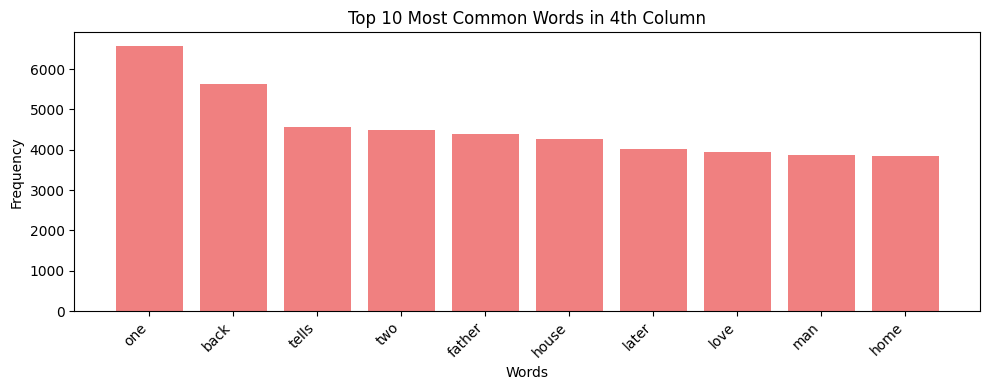

In [119]:
# Flatten all words from the 4th column into a single list after pre-processing
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

# Data after Pre Processing

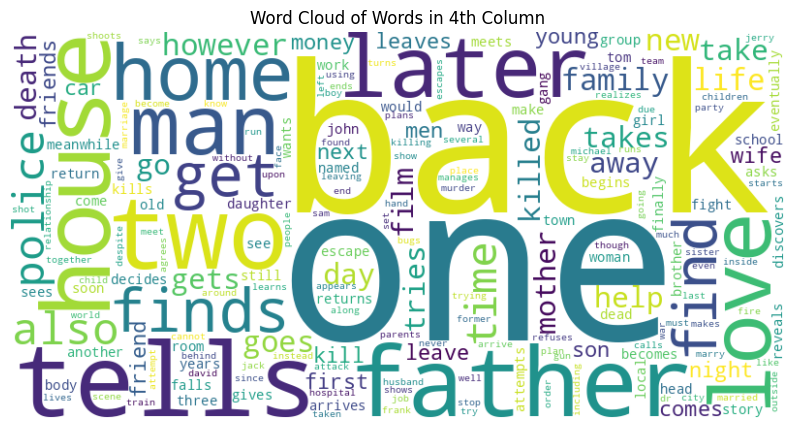

In [120]:
# Generate a word cloud after pre-processing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'newPKL'